In [1]:
import os
import numpy as np
import pandas as pd
from itertools import cycle
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, fbeta_score, accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
#     Evaluation Metrics
from itertools import cycle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from scipy import stats


def roc_auc_plot(y_true, y_pred,
                 n_classes=2, lw=2, data_title='Unspecified',
                 save_fig=True, fig_dir=r'/data/maia/mdohop/Holman_Pathway/Feeding_Tube/Models/Figures'):
    """
    plot ROC and compute auc using sklearn. Taken from https://github.com/Tony607/ROC-Keras/blob/master/ROC-Keras.ipynb.
    :param y_true: ground truth
    :param y_pred: prediction
    :param n_classes: number of classes
    :param lw: line width
    :param data_title: title of the figure
    :param save_fig: True/False; If True then saves the figure to fig_dir
    :param fig_dir: directory of the saved figure
    :return:
    """

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes
    # print(np.shape(fpr["micro"]))

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    yo_index = (1 - fpr['macro']) + 1.0*tpr['macro'] - 1
    # print('youden index al')
    # print(yo_index)
    # print(np.max(yo_index))
    index_max = np.argmax(yo_index)
    # print(np.argmax(index_max))
    yo_sensitivity = tpr['macro'][index_max]
    yo_specificity = 1-fpr['macro'][index_max]
    # print(f"max youden index sensitivity: {tpr['macro'][index_max]}")
    # print(f"max youden index specificity: {1-fpr['macro'][index_max]}")
    # print('')

    # Plot all ROC curves
    plt.figure(1)
    i = 1
    plt.plot(fpr[i], tpr[i], color='cornflowerblue', lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC--{data_title}")
    plt.legend(loc="lower right")

    if save_fig:
        os.chdir(fig_dir)
        plt.savefig(f"ROC--{data_title}")

    plt.show()
    plt.clf()

    return yo_sensitivity, yo_specificity


def sensivity_specifity_cutoff(y_true, y_score):
    '''Find data-driven cut-off for classification

    Cut-off is determined using Youden's index defined as sensitivity + specificity - 1.

    Parameters
    ----------

    y_true : array, shape = [n_samples]
        True binary labels.

    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class,
        confidence values, or non-thresholded measure of decisions (as returned by
        “decision_function” on some classifiers).

    References
    ----------

    Ewald, B. (2006). Post hoc choice of cut points introduced bias to diagnostic research.
    Journal of clinical epidemiology, 59(8), 798-801.

    Steyerberg, E.W., Van Calster, B., & Pencina, M.J. (2011). Performance measures for
    prediction models and markers: evaluation of predictions and classifications.
    Revista Espanola de Cardiologia (English Edition), 64(9), 788-794.

    Jiménez-Valverde, A., & Lobo, J.M. (2007). Threshold criteria for conversion of probability
    of species presence to either–or presence–absence. Acta oecologica, 31(3), 361-369.
    '''
    fpr, tpr, thresholds = roc_curve(y_true, y_score, drop_intermediate=True)

    idx = np.argmax(1.0*tpr - fpr)
    return thresholds[idx], thresholds



In [3]:
import pandas as pd
import numpy as np
import scipy.stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/


def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5 * (i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    log_10 = np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)
    return {'log10': log_10, 'p-value': 10 ** log_10}


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)


def delong_roc_curve_analysis(y_true=None, y_pred=None, alpha_ci=0.95):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    assert len(y_pred) == len(y_true), f"pred and label should be same length; {len(y_pred)}, {len(y_true)}"
    assert 0 < alpha_ci < 1.00, f"alpha_ci should be between 0 and 1"

    alpha = alpha_ci

    auc, auc_cov = delong_roc_variance(
        y_true,
        y_pred)

    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

    ci = stats.norm.ppf(
        lower_upper_q,
        loc=auc,
        scale=auc_std)

    ci[ci > 1] = 1

#     print('AUC:', auc)
#     print('AUC COV:', auc_cov)
#     print(f"{alpha * 100}%_ci:", ci)
#     print('')

    return {'auc': auc, f"{alpha * 100}%_ci": ci, 'auc_std': auc_std, 'auc_cov': auc_cov}

In [4]:
def roc_auc_plot_changed(y_true, y_pred,
                 n_classes=2, lw=2, data_title='Unspecified',
                 save_fig=False, fig_dir=r'/data/maia/mdohop/Holman_Pathway/Feeding_Tube/Models/Figures'):
    """
    plot ROC and compute auc using sklearn. Taken from https://github.com/Tony607/ROC-Keras/blob/master/ROC-Keras.ipynb.
    :param y_true: ground truth
    :param y_pred: prediction
    :param n_classes: number of classes
    :param lw: line width
    :param data_title: title of the figure
    :param save_fig: True/False; If True then saves the figure to fig_dir
    :param fig_dir: directory of the saved figure
    :return:
    """

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:], y_pred[:])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true, y_pred)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    yo_index = (1 - fpr['macro']) + 1.0*tpr['macro'] - 1
    # print('youden index al')
    # print(yo_index)
    # print(np.max(yo_index))
    index_max = np.argmax(yo_index)
    # print(np.argmax(index_max))
    yo_sensitivity = tpr['macro'][index_max]
    yo_specificity = 1-fpr['macro'][index_max]
    print(f"max youden index sensitivity: {tpr['macro'][index_max]}")
    print(f"max youden index specificity: {1-fpr['macro'][index_max]}")
    print('')

    # Plot all ROC curves
    plt.figure(1)
    i = 1
    plt.plot(fpr[i], tpr[i], color='cornflowerblue', lw=lw,
             label='ROC curve {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC--{data_title}")
    plt.legend(loc="lower right")

    # if save_fig:
    #     os.chdir(fig_dir)
    #     plt.savefig(f"ROC--{data_title}")

#     plt.show()
    return fpr[i], tpr[i]
#     return plt.figure(1)

def dr_friendly_measures(y_true, y_pred):
    """
    :param y_true: ground truth
    :param y_pred: prediction
    :return: specificity, sensitivity, ppv, npv
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

#     print('')
#     print('Summary of true values')
    true_values = pd.DataFrame(y_true).rename(columns={0: 'true'})
#     print(true_values.groupby('true')['true'].count())

#     print('')
#     print('Patients needing Feeding Tubes')
#     print(f"True positives: {tp}")
#     print(f"False negatives: {fn}")
#     print('')
#     print('Patients not needing Feeding Tubes')
#     print(f"False positives: {fp}")
#     print(f"True negatives: {tn}")
#     print('')

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    name1 = ['specificity', 'sensitivity', 'ppv', 'npv']
    name2 = [specificity, sensitivity, ppv, npv]

#     for i in range(len(name1)):
#         print(f"{name1[i]}: {np.round(name2[i], 3)}")

    return specificity, sensitivity, ppv, npv

In [5]:
# REDO!!

csv_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\quick_uncertainty_extraction'
# true_csv_dir = r'C:\Users\s185479\Desktop\safe_keeping\uncertainty\main_true'

def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])[0]


def simple_threshold(x, thres=0.5):
    if x >= thres:
        return 1
    else:
        return 0

cut_off_percent_list = list(np.arange(20, 90, 5))
cut_range = cut_off_percent_list
min_cut = cut_range[0]

dict_ = {'aleatoric':{}}

for i in range(5):
    dict_['aleatoric'].update({f"model_{i}":{}})

    for c in cut_off_percent_list:
        dict_['aleatoric'][f"model_{i}"].update({f"c_{c}": {'total_pred_df': None, 'h_uncert_df': None, 'l_uncert_df': None, 'total_AUC': None,
                                                           'h_AUC': None, 'l_AUC': None, 'l_correct': None, 'h_correct': None, 'total_correct': None}})



for mt in ['image']:
    for m in ['val', 'test']:
#         for s in [50, 100, 150, 200]:
        for s in [200]:
    

            # image_model_test_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_3_num300_ttafactor_3.0_rundate_2022.01.25
            test_filename = \
            [f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_1_num300_ttafactor_3.0_rundate_2022.01.25.csv", 
             f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_2_num300_ttafactor_3.0_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_3_num300_ttafactor_3.0_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_4_num300_ttafactor_3.0_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_5_num300_ttafactor_3.0_rundate_2022.01.25.csv"]
            
            pred_filename = \
            [f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_1_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv", 
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_2_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_3_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_4_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv", 
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_5_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv"]
            
            test_filename_conf = \
            [f"model_1_signif_0.05_{m}.csv", 
             f"model_2_signif_0.05_{m}.csv",
             f"model_3_signif_0.05_{m}.csv",
             f"model_4_signif_0.05_{m}.csv",
             f"model_5_signif_0.05_{m}.csv"]


            for i, f in enumerate(test_filename):
                print(i)
                print(test_filename[i])
#                 print(true_filename[i])

                df = pd.read_csv(os.path.join(csv_dir, test_filename[i]))
                df_true = pd.read_csv(os.path.join(csv_dir, test_filename_conf[i]))


                for jj, cut in enumerate(cut_off_percent_list):

                    if m == 'val':
                        percentile_val_entropy = np.percentile(df['mean_entropy'], cut)
                        optim_val_thresh = Find_Optimal_Cutoff(target=df['label'].tolist(), predicted=df_true['class_1_pred'].tolist())
                        
                    if m == 'val' and i == 0 and jj == 0:
                        save_val_list = []
                        save_val_thresh_list = []
                        save_val_list.append(percentile_val_entropy)
                        save_val_thresh_list.append(optim_val_thresh)
                    elif m == 'val':
                        save_val_list.append(percentile_val_entropy)
                        save_val_thresh_list.append(optim_val_thresh)
                        
                    elif m == 'test':
                        optim_val_thresh = save_val_thresh_list[jj]
                        
#                         print(f"{cut} percentile entropy: ", percentile_val_entropy, ' +/- ', np.std(df['mean_entropy']))

                    new_df = df
                    new_df['true'] = new_df['label']
                    new_df['pred'] = df_true['class_1_pred']
                    new_df['pred_final'] = new_df['pred'].apply(lambda x: np.where(x>=optim_val_thresh, 1, 0))
                
                    def acc(y_true, y_pred):
                        return np.sum(np.equal(y_true, y_pred)) / len(y_true)
            
            
                    from sklearn.metrics import average_precision_score
                    average = 'weighted'
                    dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['total_AUC'] = roc_auc_score(y_true=new_df['true'], y_score=new_df['pred'])
                    dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['total_prec'] = average_precision_score(y_true=new_df['true'], y_score=new_df['pred'], average=average)
                    
                    
                    
                    dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['total_acc'] = acc(y_true=new_df['true'], y_pred=new_df['pred_final'])
                    dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['total_correct'] = np.sum(new_df['true']==new_df['pred_final'])
                    
                    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=new_df['true'], y_pred=new_df['pred_final'])
                    
                    dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['total_sens'] = sensitivity
                    dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['total_spec'] = specificity


                    if m == 'test':
#                         print(save_val_list)
                        percentile_val_entropy = save_val_list[jj]
#                         optim_val_thresh = save_val_thresh_list[jj]
#                         print(percentile_val_entropy)


                        # low uncertainty
                        low_uncertainty_df = new_df.loc[new_df['mean_entropy']<percentile_val_entropy]
                        dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_uncert_df'] = low_uncertainty_df
                        dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_correct'] = np.sum(np.equal(low_uncertainty_df['true'], low_uncertainty_df['pred_final']))
                        dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_acc'] = acc(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
                        specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
                        dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_sens'] = sensitivity
                        dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_spec'] = specificity
                       
                        try:
                            dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_AUC'] = roc_auc_score(y_true=low_uncertainty_df['true'], y_score=low_uncertainty_df['pred']) 
                        except ValueError:
                            dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_AUC'] = np.nan
                            
                        try:
                            dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_prec'] = average_precision_score(y_true=low_uncertainty_df['true'], y_score=low_uncertainty_df['pred'], average=average) 
                        except ValueError:
                            dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_prec'] = np.nan
                            

                            
                        #high uncertainty 
                        high_uncertainty_df = new_df.loc[new_df['mean_entropy']>=percentile_val_entropy]
                        dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_uncert_df'] = high_uncertainty_df
                        dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_correct'] = np.sum(np.equal(high_uncertainty_df['true'], high_uncertainty_df['pred_final']))
                        dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_acc'] = acc(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
                        specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
                        dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_sens'] = sensitivity
                        dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_spec'] = specificity
                        
                        try:
                            dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_AUC'] = roc_auc_score(y_true=high_uncertainty_df['true'], y_score=high_uncertainty_df['pred'])
                        except ValueError:
                            dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_AUC'] = np.nan
                            
                        try:
                            dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_prec'] = average_precision_score(y_true=high_uncertainty_df['true'], y_score=high_uncertainty_df['pred'], average=average)
                        except ValueError:
                            dict_['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_prec'] = np.nan


        


0
image_model_val_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_1_num300_ttafactor_3.0_rundate_2022.01.25.csv
1
image_model_val_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_2_num300_ttafactor_3.0_rundate_2022.01.25.csv
2
image_model_val_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_3_num300_ttafactor_3.0_rundate_2022.01.25.csv
3
image_model_val_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_4_num300_ttafactor_3.0_rundate_2022.01.25.csv
4
image_model_val_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_5_num300_ttafactor_3.0_rundate_2022.01.25.csv
0
image_model_test_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_1_num300_ttafactor_3.0_rundate_2022.01.25.csv
1
image_model_test_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_2_num300_ttafactor_3.0_rundate_2022.01.25.csv
2
image_model_test_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_3_num300_ttafactor_3.0_rundate_2022.01.25.csv
3

C:\Users\s185479\Anaconda3\envs\Holman_Medical_Image\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in longlong_scalars



image_model_test_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_4_num300_ttafactor_3.0_rundate_2022.01.25.csv
4
image_model_test_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_5_num300_ttafactor_3.0_rundate_2022.01.25.csv


In [6]:
csv_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\quick_uncertainty_extraction'

# for validation data

def simple_threshold(x, thres=0.5):
    if x >= thres:
        return 1
    else:
        return 0


dict_val = {'aleatoric':{}}

for i in range(5):
    dict_val['aleatoric'].update({f"model_{i}":{}})

    for c in cut_off_percent_list:
        dict_val['aleatoric'][f"model_{i}"].update({f"c_{c}": {'total_pred_df': None, 'h_uncert_df': None, 'l_uncert_df': None, 'total_AUC': None,
                                                           'h_AUC': None, 'l_AUC': None, 'l_correct': None, 'h_correct': None}})



for mt in ['image']:
    for m in ['val', 'test']:
#         for s in [50, 100, 150, 200]:
        for s in [200]:
    

            # image_model_test_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_3_num300_ttafactor_3.0_rundate_2022.01.25
            test_filename = \
            [f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_1_num300_ttafactor_3.0_rundate_2022.01.25.csv", 
             f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_2_num300_ttafactor_3.0_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_3_num300_ttafactor_3.0_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_4_num300_ttafactor_3.0_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_5_num300_ttafactor_3.0_rundate_2022.01.25.csv"]
            
            pred_filename = \
            [f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_1_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv", 
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_2_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_3_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_4_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv", 
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_5_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv"]


            test_filename_conf = \
            [f"model_1_signif_0.05_{m}.csv", 
             f"model_2_signif_0.05_{m}.csv",
             f"model_3_signif_0.05_{m}.csv",
             f"model_4_signif_0.05_{m}.csv",
             f"model_5_signif_0.05_{m}.csv"]


            for i, f in enumerate(test_filename):
                print(i)
                print(test_filename[i])
#                 print(true_filename[i])

                df = pd.read_csv(os.path.join(csv_dir, test_filename[i]))
                df_true = pd.read_csv(os.path.join(csv_dir, test_filename_conf[i]))


                for jj, cut in enumerate(cut_off_percent_list):

                    if m == 'val':
                        percentile_val_entropy = np.percentile(df['mean_entropy'], cut)
                        optim_val_thresh = Find_Optimal_Cutoff(target=df['label'].tolist(), predicted=df_true['class_1_pred'].tolist())
                        
#                         print(f"{cut} percentile entropy: ", percentile_val_entropy, ' +/- ', np.std(df['mean_entropy']))

                    new_df = df
                    new_df['true'] = new_df['label']
                    new_df['pred'] = df_true['class_1_pred']
                    new_df['pred_final'] = new_df['pred'].apply(lambda x: np.where(x>=optim_val_thresh, 1, 0))
            
            
                    from sklearn.metrics import average_precision_score
                    average = 'weighted'
                    dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['total_AUC'] = roc_auc_score(y_true=new_df['true'], y_score=new_df['pred'])
                    dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['total_prec'] = average_precision_score(y_true=new_df['true'], y_score=new_df['pred'], average=average)
                    dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['total_acc'] = acc(y_true=new_df['true'], y_pred=new_df['pred_final'])
                    dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['total_correct'] = np.sum(new_df['true']==new_df['pred_final'])
                    
                    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=new_df['true'], y_pred=new_df['pred_final'])
                    
                    dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['total_sens'] = sensitivity
                    dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['total_spec'] = specificity


                    if m == 'val':

                        # low uncertainty
                        low_uncertainty_df = new_df.loc[new_df['mean_entropy']<percentile_val_entropy]
                        dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_uncert_df'] = low_uncertainty_df
                        dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_correct'] = np.sum(np.equal(low_uncertainty_df['true'], low_uncertainty_df['pred_final']))
                        dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_acc'] = acc(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
                        specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
                        dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_sens'] = sensitivity
                        dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_spec'] = specificity
                       
                        try:
                            dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_AUC'] = roc_auc_score(y_true=low_uncertainty_df['true'], y_score=low_uncertainty_df['pred']) 
                        except ValueError:
                            dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_AUC'] = np.nan
                            
                        try:
                            dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_prec'] = average_precision_score(y_true=low_uncertainty_df['true'], y_score=low_uncertainty_df['pred'], average=average) 
                        except ValueError:
                            dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['l_prec'] = np.nan
                            

                            
                        #high uncertainty 
                        high_uncertainty_df = new_df.loc[new_df['mean_entropy']>=percentile_val_entropy]
                        dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_uncert_df'] = high_uncertainty_df
                        dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_correct'] = np.sum(np.equal(high_uncertainty_df['true'], high_uncertainty_df['pred_final']))
                        dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_acc'] = acc(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
                        specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
                        dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_sens'] = sensitivity
                        dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_spec'] = specificity
                        
                        try:
                            dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_AUC'] = roc_auc_score(y_true=high_uncertainty_df['true'], y_score=high_uncertainty_df['pred'])
                        except ValueError:
                            dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_AUC'] = np.nan
                            
                        try:
                            dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_prec'] = average_precision_score(y_true=high_uncertainty_df['true'], y_score=high_uncertainty_df['pred'], average=average)
                        except ValueError:
                            dict_val['aleatoric'][f"model_{i}"][f"c_{cut}"]['h_prec'] = np.nan
        


0
image_model_val_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_1_num300_ttafactor_3.0_rundate_2022.01.25.csv
1
image_model_val_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_2_num300_ttafactor_3.0_rundate_2022.01.25.csv
2
image_model_val_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_3_num300_ttafactor_3.0_rundate_2022.01.25.csv
3
image_model_val_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_4_num300_ttafactor_3.0_rundate_2022.01.25.csv
4
image_model_val_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_5_num300_ttafactor_3.0_rundate_2022.01.25.csv
0
image_model_test_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_1_num300_ttafactor_3.0_rundate_2022.01.25.csv
1
image_model_test_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_2_num300_ttafactor_3.0_rundate_2022.01.25.csv
2
image_model_test_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_3_num300_ttafactor_3.0_rundate_2022.01.25.csv
3
image_model_test_aleatoric_

testing
********************************************************************************
model 0


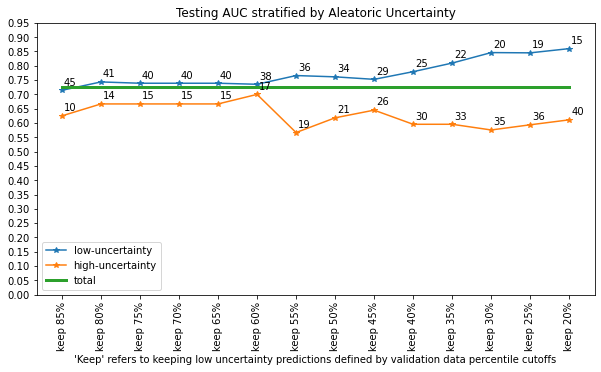

********************************************************************************
model 1


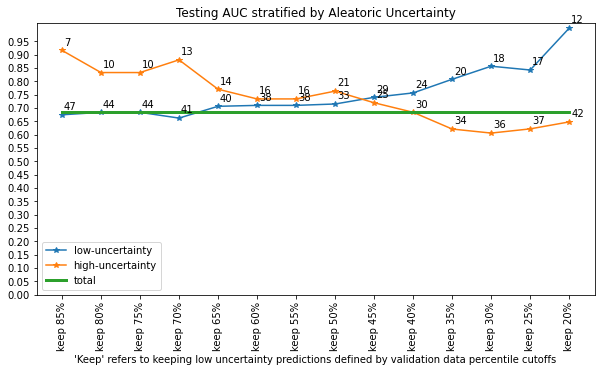

********************************************************************************
model 2


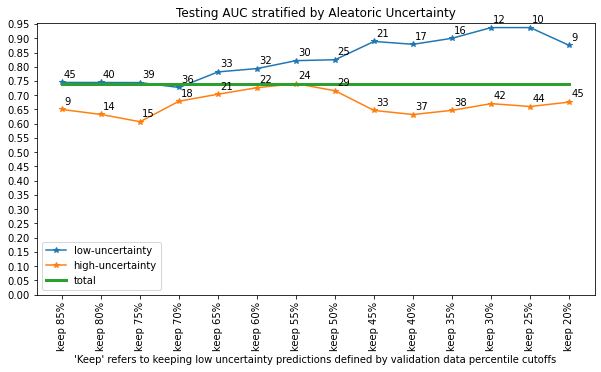

********************************************************************************
model 3


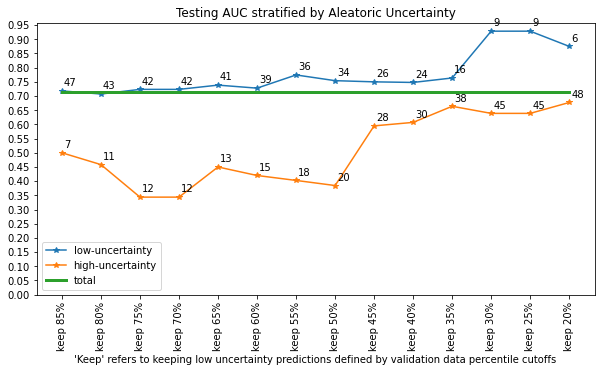

********************************************************************************
model 4


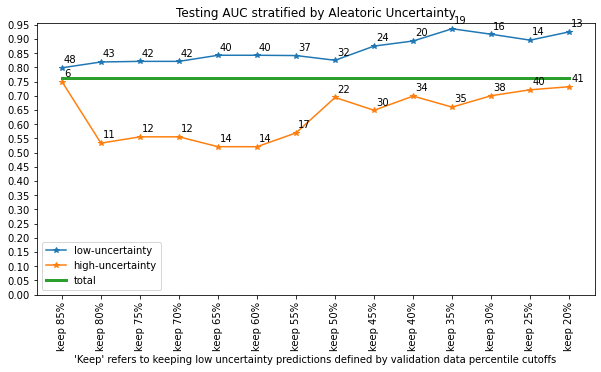

In [7]:
print('testing')

dict_
for m in range(5):
    print('*'*80)
    print(f"model {m}")

    high_uncertainty = [dict_['aleatoric'][f"model_{m}"][x]['h_AUC'] for x in dict_['aleatoric'][f"model_{m}"] 
                        if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    high_uncertainty_num = [np.shape(dict_['aleatoric'][f"model_{m}"][x]['h_uncert_df'])[0] for x in dict_['aleatoric'][f"model_{m}"] 
                            if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]


    low_uncertainty = [dict_['aleatoric'][f"model_{m}"][x]['l_AUC'] for x in dict_['aleatoric'][f"model_{m}"] 
                       if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    low_uncertainty_num = [np.shape(dict_['aleatoric'][f"model_{m}"][x]['l_uncert_df'])[0] for x in dict_['aleatoric'][f"model_{m}"] 
                           if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]


    cutoff = [x.split('_')[-1] for x in dict_['aleatoric'][f"model_{m}"] 
              if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    
    cutoff = cutoff[::-1]
    low_uncertainty = low_uncertainty[::-1]
    low_uncertainty_num = low_uncertainty_num[::-1]
    
    high_uncertainty = high_uncertainty[::-1]
    high_uncertainty_num = high_uncertainty_num[::-1]


    plt.figure(figsize=(10,5))

    plt.plot([int(x) for x in cutoff], low_uncertainty, '-*')
    
    for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
        plt.annotate(str(txt), ([int(x) for x in cutoff][i], low_uncertainty[i]), 
                     xycoords='data', textcoords='offset points', xytext=(2, 5))
    
    plt.plot([int(x) for x in cutoff], high_uncertainty, '*-')
    for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
        plt.annotate(str(txt), ([int(x) for x in cutoff][i], high_uncertainty[i]), 
                     xycoords='data', textcoords='offset points', xytext=(2, 5))
    
    
    plt.plot([int(x) for x in cutoff], [dict_['aleatoric'][f"model_{m}"][x]['total_AUC'] for x in dict_['aleatoric'][f"model_{m}"] 
              if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range], linewidth=3)
    
    plt.legend(['low-uncertainty', 'high-uncertainty','total'], loc='lower left')
    plt.yticks(np.arange(0.0, 1, 0.05))
    plt.gca().invert_xaxis()
    plt.xticks([int(x) for x in cutoff], [f"keep {str(x)}%" for x in cutoff])
    plt.xticks(rotation = 90)
    plt.xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs")

    plt.title('Testing AUC stratified by Aleatoric Uncertainty')
    
    plt.show()

validation total data


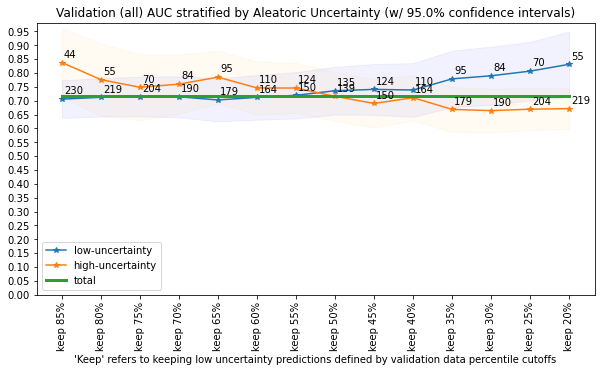

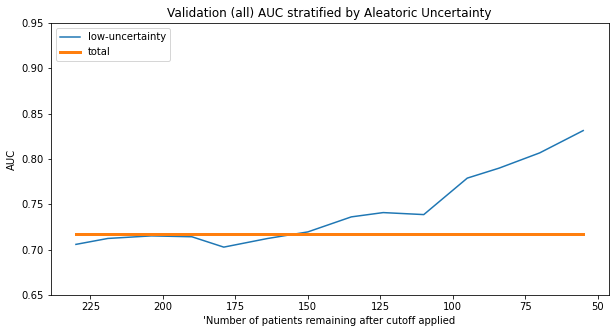


Evaluating the ratio of ft/(no ft + ft)
+ then -
[17, 23, 25, 28, 39, 43, 50, 55, 61, 70, 77, 83, 89, 95]
[38, 47, 59, 67, 71, 81, 85, 95, 103, 109, 113, 121, 130, 135]
[0.30909091 0.32857143 0.29761905 0.29473684 0.35454545 0.34677419
 0.37037037 0.36666667 0.37195122 0.39106145 0.40526316 0.40686275
 0.40639269 0.41304348]

+ then -
[98, 92, 90, 87, 76, 72, 65, 60, 54, 45, 38, 32, 26, 20]
[121, 112, 100, 92, 88, 78, 74, 64, 56, 50, 46, 38, 29, 24]
[0.44748858 0.45098039 0.47368421 0.48603352 0.46341463 0.48
 0.4676259  0.48387097 0.49090909 0.47368421 0.45238095 0.45714286
 0.47272727 0.45454545]


In [8]:
print('validation total data')

conf_int = 0.95
dict_val

total_eval_dict = {x: {} for x in cut_range}


for c in cut_range:
    high_uncertainty_df = None
    low_uncertainty_df = None
    for m in range(5):
        if m == 0:
            high_uncertainty_df = dict_val['aleatoric'][f"model_{m}"][f"c_{c}"]['h_uncert_df']
            low_uncertainty_df = dict_val['aleatoric'][f"model_{m}"][f"c_{c}"]['l_uncert_df']
        else:
            high_uncertainty_df = pd.concat([high_uncertainty_df, dict_val['aleatoric'][f"model_{m}"][f"c_{c}"]['h_uncert_df']])
            low_uncertainty_df = pd.concat([low_uncertainty_df, dict_val['aleatoric'][f"model_{m}"][f"c_{c}"]['l_uncert_df']])

        
    total_eval_dict[c]['total_df'] = pd.concat([high_uncertainty_df, low_uncertainty_df])
    total_eval_dict[c]['total_auc'] = roc_auc_score(y_true=total_eval_dict[c]['total_df']['true'], y_score=total_eval_dict[c]['total_df']['pred']) 
    total_eval_dict[c]['total_auc_95_conf'] = delong_roc_curve_analysis(y_true=total_eval_dict[c]['total_df']['true'], y_pred=total_eval_dict[c]['total_df']['pred'], alpha_ci=conf_int)[f"{conf_int*100}%_ci"]

    total_eval_dict[c]['high_uncertainty_df'] = high_uncertainty_df
    total_eval_dict[c]['high_uncertainty_num'] = np.shape(high_uncertainty_df)[0]

    try:
        total_eval_dict[c]['h_AUC'] = roc_auc_score(y_true=high_uncertainty_df['true'], y_score=high_uncertainty_df['pred']) 
        total_eval_dict[c]['h_AUC_95conf'] = delong_roc_curve_analysis(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred'], alpha_ci=conf_int)[f"{conf_int*100}%_ci"]
    except ValueError:
        total_eval_dict[c]['h_AUC'] = np.nan
        total_eval_dict[c]['h_AUC_95conf'] = np.array([np.nan, np.nan])

    total_eval_dict[c]['low_uncertainty_df'] = low_uncertainty_df
    total_eval_dict[c]['low_uncertainty_num'] = np.shape(low_uncertainty_df)[0]

    try:
        total_eval_dict[c]['l_AUC'] = roc_auc_score(y_true=low_uncertainty_df['true'], y_score=low_uncertainty_df['pred']) 
        total_eval_dict[c]['l_AUC_95conf'] = delong_roc_curve_analysis(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred'], alpha_ci=conf_int)[f"{conf_int*100}%_ci"]
    except ValueError:
        total_eval_dict[c]['l_AUC'] = np.nan
        total_eval_dict[c]['l_AUC_95conf'] = np.array([np.nan, np.nan])
        
        
    total_eval_dict[c]['low_num_pos'] = np.sum(low_uncertainty_df['true'])
    total_eval_dict[c]['low_num_neg'] = len(low_uncertainty_df['true']) - np.sum(low_uncertainty_df['true'])

    total_eval_dict[c]['high_num_pos'] = np.sum(high_uncertainty_df['true'])
    total_eval_dict[c]['high_num_neg'] = len(high_uncertainty_df['true']) - np.sum(high_uncertainty_df['true'])



import pprint
# pprint.pprint(total_eval_dict)

# assert 1 == 0, 'force'

cutoff = cut_range
cutoff = cutoff[::-1]

plt.figure(figsize=(10,5))

low_uncertainty = [total_eval_dict[c]['l_AUC'] for c in cutoff]
low_uncertainty_num = [total_eval_dict[c]['low_uncertainty_num'] for c in cutoff]

low_conf_interval_low = [total_eval_dict[c]['l_AUC_95conf'][0] for c in cutoff]
low_conf_interval_high = [total_eval_dict[c]['l_AUC_95conf'][1] for c in cutoff]

high_conf_interval_low = [total_eval_dict[c]['h_AUC_95conf'][0] for c in cutoff]
high_conf_interval_high = [total_eval_dict[c]['h_AUC_95conf'][1] for c in cutoff]

# low_uncertainty = low_uncertainty[::-1]
# low_uncertainty_num = low_uncertainty_num[::-1]
    

plt.plot([int(x) for x in cutoff], low_uncertainty, '-*')
plt.fill_between([int(x) for x in cutoff], (low_conf_interval_low), (low_conf_interval_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    plt.annotate(str(txt), ([int(x) for x in cutoff][i], low_uncertainty[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))

high_uncertainty = [total_eval_dict[c]['h_AUC'] for c in cutoff]
high_uncertainty_num = [total_eval_dict[c]['high_uncertainty_num'] for c in cutoff]    

# high_uncertainty = high_uncertainty[::-1]
# high_uncertainty_num = high_uncertainty_num[::-1]

plt.plot([int(x) for x in cutoff], high_uncertainty, '*-')
plt.fill_between([int(x) for x in cutoff], (high_conf_interval_low), (high_conf_interval_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    plt.annotate(str(txt), ([int(x) for x in cutoff][i], high_uncertainty[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))

plt.plot([int(x) for x in cutoff], [total_eval_dict[x]['total_auc'] for x in cut_range], linewidth=3)

plt.legend(['low-uncertainty', 'high-uncertainty','total'], loc='lower left')
plt.yticks(np.arange(0.0, 1, 0.05))
plt.gca().invert_xaxis()
plt.xticks([int(x) for x in cutoff], [f"keep {str(x)}%" for x in cutoff])
plt.xticks(rotation = 90)
plt.xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs")

plt.title(f"Validation (all) AUC stratified by Aleatoric Uncertainty (w/ {conf_int*100}% confidence intervals)")

plt.show()

# AUC per patient number
plt.figure(figsize=(10,5))
plt.plot(low_uncertainty_num, low_uncertainty)
plt.plot(low_uncertainty_num, [total_eval_dict[50]['total_auc'] for x in range(len(low_uncertainty_num))], linewidth=3)
plt.legend(['low-uncertainty', 'total'], loc='upper left')
plt.yticks(np.arange(0.65, 1, 0.05))
plt.xlabel("'Number of patients remaining after cutoff applied")
plt.ylabel('AUC')
plt.title(f"Validation (all) AUC stratified by Aleatoric Uncertainty")

plt.gca().invert_xaxis()
plt.show()

save_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_miccai\save_folder'
f_name = 'val_tta.csv'
df = pd.DataFrame([[low_uncertainty_num, low_uncertainty, [total_eval_dict[50]['total_auc'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'l_auc', 'total_auc'])
df.to_csv(os.path.join(save_dir, f_name))

f_name = 'val_tta_wrong.csv'
df = pd.DataFrame([[high_uncertainty_num, high_uncertainty, [total_eval_dict[50]['total_auc'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'h_auc', 'total_auc'])
df.to_csv(os.path.join(save_dir, f_name))

save_ratio_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_miccai\ratio'
if not os.path.exists(save_ratio_dir):
    os.mkdir(save_ratio_dir)
else:
    pass

low_ratio_name = 'val_tta.npy'
high_ratio_name = 'val_tta_wrong.npy'

print('')
print('Evaluating the ratio of ft/(no ft + ft)')
print('+ then -')
print([total_eval_dict[c]['low_num_pos'] for c in total_eval_dict])
print([total_eval_dict[c]['low_num_neg'] for c in total_eval_dict])
low_ratio = np.divide([total_eval_dict[c]['low_num_pos'] for c in total_eval_dict], np.add([total_eval_dict[c]['low_num_neg'] for c in total_eval_dict], [total_eval_dict[c]['low_num_pos'] for c in total_eval_dict]))
print(low_ratio)
np.save(os.path.join(save_ratio_dir, low_ratio_name), low_ratio)

print('')
print('+ then -')
print([total_eval_dict[c]['high_num_pos'] for c in total_eval_dict])
print([total_eval_dict[c]['high_num_neg'] for c in total_eval_dict])
high_ratio = np.divide([total_eval_dict[c]['high_num_pos'] for c in total_eval_dict], np.add([total_eval_dict[c]['high_num_neg'] for c in total_eval_dict], [total_eval_dict[c]['high_num_pos'] for c in total_eval_dict]))
print(high_ratio)
np.save(os.path.join(save_ratio_dir, high_ratio_name), high_ratio)

testing total data


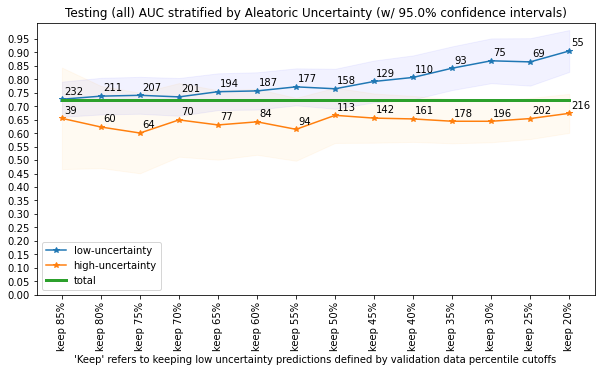

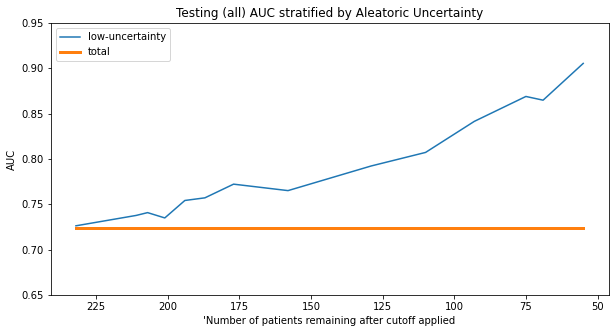


Evaluating the ratio of ft/(no ft + ft)
+ then -
[18, 24, 26, 33, 39, 48, 58, 68, 70, 73, 76, 78, 80, 93]
[37, 45, 49, 60, 71, 81, 100, 109, 117, 121, 125, 129, 131, 139]
[0.32727273 0.34782609 0.34666667 0.35483871 0.35454545 0.37209302
 0.36708861 0.38418079 0.37433155 0.37628866 0.37810945 0.37681159
 0.37914692 0.40086207]

+ then -
[97, 91, 89, 82, 76, 67, 57, 47, 45, 42, 39, 37, 35, 22]
[119, 111, 107, 96, 85, 75, 56, 47, 39, 35, 31, 27, 25, 17]
[0.44907407 0.45049505 0.45408163 0.46067416 0.47204969 0.47183099
 0.50442478 0.5        0.53571429 0.54545455 0.55714286 0.578125
 0.58333333 0.56410256]


In [9]:
print('testing total data')

conf_int = 0.95

dict_

total_eval_dict = {x: {} for x in cut_range}

for c in cut_range:
    high_uncertainty_df = None
    low_uncertainty_df = None
    for m in range(5):
        if m == 0:
            high_uncertainty_df = dict_['aleatoric'][f"model_{m}"][f"c_{c}"]['h_uncert_df']
            low_uncertainty_df = dict_['aleatoric'][f"model_{m}"][f"c_{c}"]['l_uncert_df']
        else:
            high_uncertainty_df = pd.concat([high_uncertainty_df, dict_['aleatoric'][f"model_{m}"][f"c_{c}"]['h_uncert_df']])
            low_uncertainty_df = pd.concat([low_uncertainty_df, dict_['aleatoric'][f"model_{m}"][f"c_{c}"]['l_uncert_df']])

        
    total_eval_dict[c]['total_df'] = pd.concat([high_uncertainty_df, low_uncertainty_df])
    total_eval_dict[c]['total_auc'] = roc_auc_score(y_true=total_eval_dict[c]['total_df']['true'], y_score=total_eval_dict[c]['total_df']['pred']) 
    total_eval_dict[c]['total_auc_95_conf'] = delong_roc_curve_analysis(y_true=total_eval_dict[c]['total_df']['true'], y_pred=total_eval_dict[c]['total_df']['pred'], alpha_ci=conf_int)[f"{conf_int*100}%_ci"]

    total_eval_dict[c]['high_uncertainty_df'] = high_uncertainty_df
    total_eval_dict[c]['high_uncertainty_num'] = np.shape(high_uncertainty_df)[0]

    try:
        total_eval_dict[c]['h_AUC'] = roc_auc_score(y_true=high_uncertainty_df['true'], y_score=high_uncertainty_df['pred']) 
        total_eval_dict[c]['h_AUC_95conf'] = delong_roc_curve_analysis(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred'], alpha_ci=conf_int)[f"{conf_int*100}%_ci"]
    except ValueError:
        total_eval_dict[c]['h_AUC'] = np.nan
        total_eval_dict[c]['h_AUC_95conf'] = np.array([np.nan, np.nan])

    total_eval_dict[c]['low_uncertainty_df'] = low_uncertainty_df
    total_eval_dict[c]['low_uncertainty_num'] = np.shape(low_uncertainty_df)[0]

    try:
        total_eval_dict[c]['l_AUC'] = roc_auc_score(y_true=low_uncertainty_df['true'], y_score=low_uncertainty_df['pred']) 
        total_eval_dict[c]['l_AUC_95conf'] = delong_roc_curve_analysis(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred'], alpha_ci=conf_int)[f"{conf_int*100}%_ci"]
    except ValueError:
        total_eval_dict[c]['l_AUC'] = np.nan
        total_eval_dict[c]['l_AUC_95conf'] = np.array([np.nan, np.nan])
        
        
    total_eval_dict[c]['low_num_pos'] = np.sum(low_uncertainty_df['true'])
    total_eval_dict[c]['low_num_neg'] = len(low_uncertainty_df['true']) - np.sum(low_uncertainty_df['true'])

    total_eval_dict[c]['high_num_pos'] = np.sum(high_uncertainty_df['true'])
    total_eval_dict[c]['high_num_neg'] = len(high_uncertainty_df['true']) - np.sum(high_uncertainty_df['true'])


cutoff = cut_range[::-1]

plt.figure(figsize=(10,5))

low_uncertainty = [total_eval_dict[c]['l_AUC'] for c in cutoff]
low_uncertainty_num = [total_eval_dict[c]['low_uncertainty_num'] for c in cutoff]

low_uncertainty = [total_eval_dict[c]['l_AUC'] for c in cutoff]
low_uncertainty_num = [total_eval_dict[c]['low_uncertainty_num'] for c in cutoff]

low_conf_interval_low = [total_eval_dict[c]['l_AUC_95conf'][0] for c in cutoff]
low_conf_interval_high = [total_eval_dict[c]['l_AUC_95conf'][1] for c in cutoff]

high_conf_interval_low = [total_eval_dict[c]['h_AUC_95conf'][0] for c in cutoff]
high_conf_interval_high = [total_eval_dict[c]['h_AUC_95conf'][1] for c in cutoff]

plt.plot([int(x) for x in cutoff], low_uncertainty, '-*')
plt.fill_between([int(x) for x in cutoff], (low_conf_interval_low), (low_conf_interval_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    plt.annotate(str(txt), ([int(x) for x in cutoff][i], low_uncertainty[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))

high_uncertainty = [total_eval_dict[c]['h_AUC'] for c in cutoff]
high_uncertainty_num = [total_eval_dict[c]['high_uncertainty_num'] for c in cutoff]    

plt.plot([int(x) for x in cutoff], high_uncertainty, '*-')
plt.fill_between([int(x) for x in cutoff], (high_conf_interval_low), (high_conf_interval_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    plt.annotate(str(txt), ([int(x) for x in cutoff][i], high_uncertainty[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))

plt.plot([int(x) for x in cutoff], [total_eval_dict[x]['total_auc'] for x in cut_range], linewidth=3)

plt.legend(['low-uncertainty', 'high-uncertainty','total'], loc='lower left')
plt.yticks(np.arange(0.0, 1, 0.05))
plt.gca().invert_xaxis()
plt.xticks([int(x) for x in cutoff], [f"keep {str(x)}%" for x in cutoff])
plt.xticks(rotation = 90)
plt.xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs")

plt.title(f"Testing (all) AUC stratified by Aleatoric Uncertainty (w/ {conf_int*100}% confidence intervals)")

plt.show()

# AUC per patient number
plt.figure(figsize=(10,5))
plt.plot(low_uncertainty_num, low_uncertainty)
plt.plot(low_uncertainty_num, [total_eval_dict[50]['total_auc'] for x in range(len(low_uncertainty_num))], linewidth=3)
plt.legend(['low-uncertainty', 'total'], loc='upper left')
plt.yticks(np.arange(0.65, 1, 0.05))
plt.xlabel("'Number of patients remaining after cutoff applied")
plt.ylabel('AUC')
plt.title(f"Testing (all) AUC stratified by Aleatoric Uncertainty")

plt.gca().invert_xaxis()
plt.show()

save_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_miccai\save_folder'
f_name = 'test_tta.csv'
df = pd.DataFrame([[low_uncertainty_num, low_uncertainty, [total_eval_dict[50]['total_auc'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'l_auc', 'total_auc'])
df.to_csv(os.path.join(save_dir, f_name))

f_name = 'test_tta_wrong.csv'
df = pd.DataFrame([[high_uncertainty_num, high_uncertainty, [total_eval_dict[50]['total_auc'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'h_auc', 'total_auc'])
df.to_csv(os.path.join(save_dir, f_name))

save_ratio_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_miccai\ratio'
if not os.path.exists(save_ratio_dir):
    os.mkdir(save_ratio_dir)
else:
    pass

low_ratio_name = 'test_tta.npy'
high_ratio_name = 'test_tta_wrong.npy'

print('')
print('Evaluating the ratio of ft/(no ft + ft)')
print('+ then -')
print([total_eval_dict[c]['low_num_pos'] for c in total_eval_dict])
print([total_eval_dict[c]['low_num_neg'] for c in total_eval_dict])
low_ratio = np.divide([total_eval_dict[c]['low_num_pos'] for c in total_eval_dict], np.add([total_eval_dict[c]['low_num_neg'] for c in total_eval_dict], [total_eval_dict[c]['low_num_pos'] for c in total_eval_dict]))
print(low_ratio)
np.save(os.path.join(save_ratio_dir, low_ratio_name), low_ratio)

print('')
print('+ then -')
print([total_eval_dict[c]['high_num_pos'] for c in total_eval_dict])
print([total_eval_dict[c]['high_num_neg'] for c in total_eval_dict])
high_ratio = np.divide([total_eval_dict[c]['high_num_pos'] for c in total_eval_dict], np.add([total_eval_dict[c]['high_num_neg'] for c in total_eval_dict], [total_eval_dict[c]['high_num_pos'] for c in total_eval_dict]))
print(high_ratio)
np.save(os.path.join(save_ratio_dir, high_ratio_name), high_ratio)

testing acc
********************************************************************************
model 0


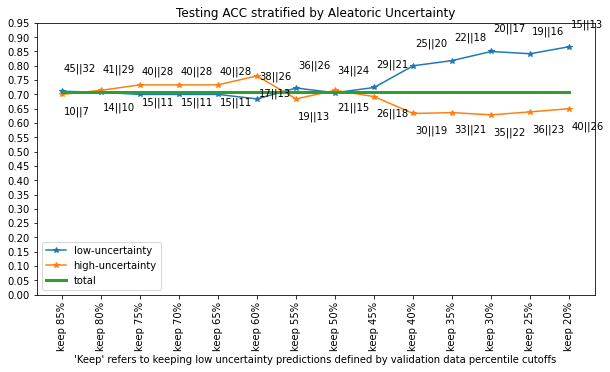

********************************************************************************
model 1


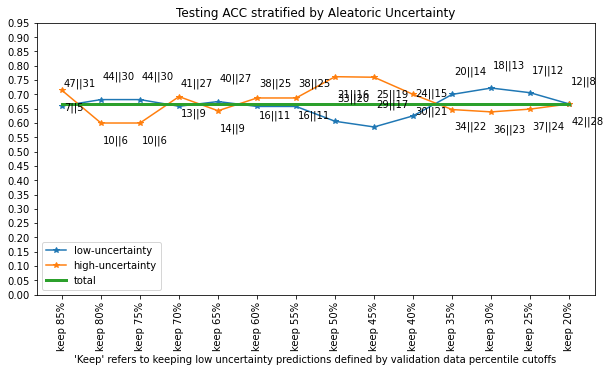

********************************************************************************
model 2


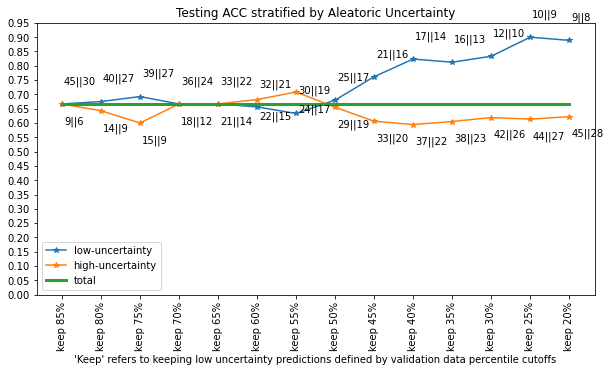

********************************************************************************
model 3


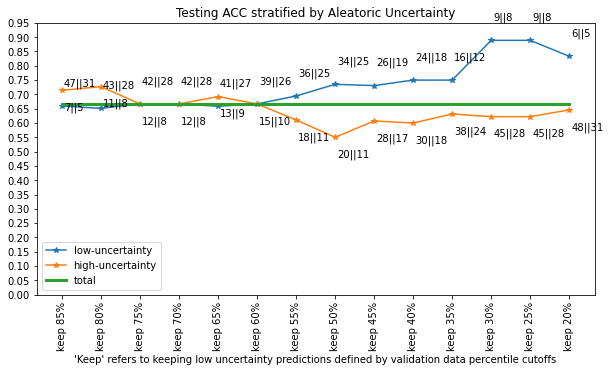

********************************************************************************
model 4


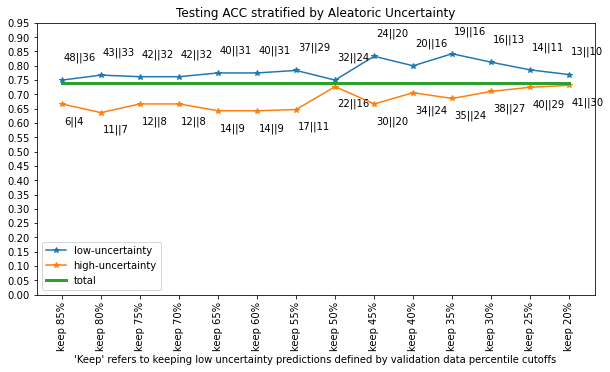

In [10]:
print('testing acc')

dict_
for m in range(5):
    print('*'*80)
    print(f"model {m}")

    high_uncertainty_num = [np.shape(dict_['aleatoric'][f"model_{m}"][x]['h_uncert_df'])[0] for x in dict_['aleatoric'][f"model_{m}"] 
                            if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    
    high_acc = [dict_['aleatoric'][f"model_{m}"][x]['h_acc'] for x in dict_['aleatoric'][f"model_{m}"] 
                        if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    
    h_correct = [dict_['aleatoric'][f"model_{m}"][x]['h_correct'] for x in dict_['aleatoric'][f"model_{m}"] 
                        if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]


    low_uncertainty_num = [np.shape(dict_['aleatoric'][f"model_{m}"][x]['l_uncert_df'])[0] for x in dict_['aleatoric'][f"model_{m}"] 
                           if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    
    low_acc = [dict_['aleatoric'][f"model_{m}"][x]['l_acc'] for x in dict_['aleatoric'][f"model_{m}"] 
                       if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    
    l_correct = [dict_['aleatoric'][f"model_{m}"][x]['l_correct'] for x in dict_['aleatoric'][f"model_{m}"] 
                       if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]


    cutoff = [x.split('_')[-1] for x in dict_['aleatoric'][f"model_{m}"] 
              if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]


    plt.figure(figsize=(10,5))

    plt.plot([int(x) for x in cutoff], low_acc, '-*')
    
    for i, txt in enumerate(list(zip([str(x) for x in low_uncertainty_num], l_correct))):
        plt.annotate(str(txt[0])+'||'+str(txt[1]), ([int(x) for x in cutoff][i], low_acc[i]), 
                     xycoords='data', textcoords='offset points', xytext=(2, 20))
    
    plt.plot([int(x) for x in cutoff], high_acc, '*-')
    for i, txt in enumerate(list(zip([str(x) for x in high_uncertainty_num], h_correct))):
        plt.annotate(str(txt[0])+'||'+str(txt[1]), ([int(x) for x in cutoff][i], high_acc[i]), 
                     xycoords='data', textcoords='offset points', xytext=(2, -20))
    
    
    plt.plot([int(x) for x in cutoff], [dict_['aleatoric'][f"model_{m}"][x]['total_acc'] for x in dict_['aleatoric'][f"model_{m}"] 
              if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range], linewidth=3)
    
    plt.legend(['low-uncertainty', 'high-uncertainty','total'], loc='lower left')
    plt.yticks(np.arange(0.0, 1, 0.05))
    plt.gca().invert_xaxis()
    plt.xticks([int(x) for x in cutoff], [f"keep {str(x)}%" for x in cutoff])
    plt.xticks(rotation = 90)
    plt.xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs")
    

    plt.title('Testing ACC stratified by Aleatoric Uncertainty')
    
    plt.show()

val total data


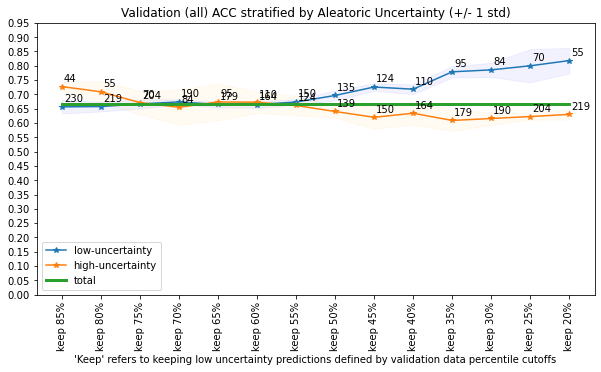

In [11]:
print('val total data')

std_num = 1

dict_val

total_eval_dict = {x: {} for x in cut_range}


for c in cut_range:
    high_uncertainty_df = None
    low_uncertainty_df = None
    cut_low_acc = []
    cut_high_acc = []
    for m in range(5):
        if m == 0:
            high_uncertainty_df = dict_val['aleatoric'][f"model_{m}"][f"c_{c}"]['h_uncert_df']
            low_uncertainty_df = dict_val['aleatoric'][f"model_{m}"][f"c_{c}"]['l_uncert_df']
            
            cut_low_acc.append(acc(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final']))
            cut_high_acc.append(acc(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final']))
            
        else:
            high_uncertainty_df = pd.concat([high_uncertainty_df, dict_val['aleatoric'][f"model_{m}"][f"c_{c}"]['h_uncert_df']])
            low_uncertainty_df = pd.concat([low_uncertainty_df, dict_val['aleatoric'][f"model_{m}"][f"c_{c}"]['l_uncert_df']])
            
            cut_low_acc.append(acc(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final']))
            cut_high_acc.append(acc(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final']))

        
    total_eval_dict[c]['total_df'] = pd.concat([high_uncertainty_df, low_uncertainty_df])
    total_eval_dict[c]['total_acc'] = acc(y_true=total_eval_dict[c]['total_df']['true'], y_pred=total_eval_dict[c]['total_df']['pred_final'])  
    total_eval_dict[c]['fold_l_acc'] = cut_low_acc
    total_eval_dict[c]['fold_h_acc'] = cut_high_acc
    total_eval_dict[c]['high_uncertainty_df'] = high_uncertainty_df
    total_eval_dict[c]['high_uncertainty_num'] = np.shape(high_uncertainty_df)[0]

    try:
        total_eval_dict[c]['h_acc'] = acc(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final']) 
        total_eval_dict[c]['h_acc_std'] = np.std(total_eval_dict[c]['fold_h_acc'])
    except ValueError:
        total_eval_dict[c]['h_acc'] = np.nan
        total_eval_dict[c]['h_acc_std'] = np.nan

    total_eval_dict[c]['low_uncertainty_df'] = low_uncertainty_df
    total_eval_dict[c]['low_uncertainty_num'] = np.shape(low_uncertainty_df)[0]

    try:
        total_eval_dict[c]['l_acc'] = acc(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final']) 
        total_eval_dict[c]['l_acc_std'] = np.std(total_eval_dict[c]['fold_l_acc'])
    except ValueError:
        total_eval_dict[c]['l_acc'] = np.nan
        total_eval_dict[c]['l_acc_std'] = np.nan
        

import pprint

cutoff = cut_range
cutoff = cutoff[::-1]

plt.figure(figsize=(10,5))

low_uncertainty = [total_eval_dict[c]['l_acc'] for c in cutoff]
low_uncertainty_num = [total_eval_dict[c]['low_uncertainty_num'] for c in cutoff]
low_std_low = [total_eval_dict[c]['l_acc'] - std_num*total_eval_dict[c]['l_acc_std'] for c in cutoff]
low_std_high = [total_eval_dict[c]['l_acc'] + std_num*total_eval_dict[c]['l_acc_std'] for c in cutoff]


plt.plot([int(x) for x in cutoff], low_uncertainty, '-*')
plt.fill_between([int(x) for x in cutoff], (low_std_low), (low_std_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    plt.annotate(str(txt), ([int(x) for x in cutoff][i], low_uncertainty[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))

high_uncertainty = [total_eval_dict[c]['h_acc'] for c in cutoff]
high_uncertainty_num = [total_eval_dict[c]['high_uncertainty_num'] for c in cutoff]    
high_std_low = [total_eval_dict[c]['h_acc'] - std_num*total_eval_dict[c]['h_acc_std'] for c in cutoff]
high_std_high = [total_eval_dict[c]['h_acc'] + std_num*total_eval_dict[c]['h_acc_std'] for c in cutoff]

plt.plot([int(x) for x in cutoff], high_uncertainty, '*-')
plt.fill_between([int(x) for x in cutoff], (high_std_low), (high_std_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    plt.annotate(str(txt), ([int(x) for x in cutoff][i], high_uncertainty[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))

plt.plot([int(x) for x in cutoff], [total_eval_dict[x]['total_acc'] for x in cut_range], linewidth=3)

plt.legend(['low-uncertainty', 'high-uncertainty','total'], loc='lower left')
plt.yticks(np.arange(0.0, 1, 0.05))
plt.gca().invert_xaxis()
plt.xticks([int(x) for x in cutoff], [f"keep {str(x)}%" for x in cutoff])
plt.xticks(rotation = 90)
plt.xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs")

plt.title(f"Validation (all) ACC stratified by Aleatoric Uncertainty (+/- {std_num} std)")

plt.show()

testing total data


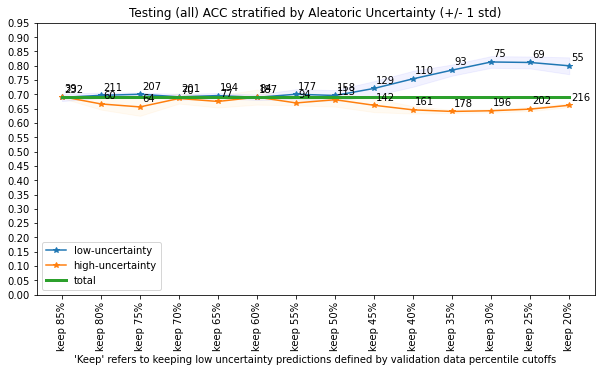

In [12]:
print('testing total data')

std_num = 1

dict_

total_eval_dict = {x: {} for x in cut_range}


for c in cut_range:
    high_uncertainty_df = None
    low_uncertainty_df = None
    cut_low_acc = []
    cut_high_acc = []
    for m in range(5):
        if m == 0:
            high_uncertainty_df = dict_['aleatoric'][f"model_{m}"][f"c_{c}"]['h_uncert_df']
            low_uncertainty_df = dict_['aleatoric'][f"model_{m}"][f"c_{c}"]['l_uncert_df']
            
            cut_low_acc.append(acc(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final']))
            cut_high_acc.append(acc(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final']))
            
        else:
            high_uncertainty_df = pd.concat([high_uncertainty_df, dict_['aleatoric'][f"model_{m}"][f"c_{c}"]['h_uncert_df']])
            low_uncertainty_df = pd.concat([low_uncertainty_df, dict_['aleatoric'][f"model_{m}"][f"c_{c}"]['l_uncert_df']])
            
            cut_low_acc.append(acc(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final']))
            cut_high_acc.append(acc(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final']))

        
    total_eval_dict[c]['total_df'] = pd.concat([high_uncertainty_df, low_uncertainty_df])
    total_eval_dict[c]['total_acc'] = acc(y_true=total_eval_dict[c]['total_df']['true'], y_pred=total_eval_dict[c]['total_df']['pred_final'])  
    total_eval_dict[c]['fold_l_acc'] = cut_low_acc
    total_eval_dict[c]['fold_h_acc'] = cut_high_acc
    total_eval_dict[c]['high_uncertainty_df'] = high_uncertainty_df
    total_eval_dict[c]['high_uncertainty_num'] = np.shape(high_uncertainty_df)[0]

    try:
        total_eval_dict[c]['h_acc'] = acc(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final']) 
        total_eval_dict[c]['h_acc_std'] = np.std(total_eval_dict[c]['fold_h_acc'])
    except ValueError:
        total_eval_dict[c]['h_acc'] = np.nan
        total_eval_dict[c]['h_acc_std'] = np.nan

    total_eval_dict[c]['low_uncertainty_df'] = low_uncertainty_df
    total_eval_dict[c]['low_uncertainty_num'] = np.shape(low_uncertainty_df)[0]

    try:
        total_eval_dict[c]['l_acc'] = acc(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final']) 
        total_eval_dict[c]['l_acc_std'] = np.std(total_eval_dict[c]['fold_l_acc'])
    except ValueError:
        total_eval_dict[c]['l_acc'] = np.nan
        total_eval_dict[c]['l_acc_std'] = np.nan
        

import pprint

cutoff = cut_range
cutoff = cutoff[::-1]

plt.figure(figsize=(10,5))

low_uncertainty = [total_eval_dict[c]['l_acc'] for c in cutoff]
low_uncertainty_num = [total_eval_dict[c]['low_uncertainty_num'] for c in cutoff]
low_std_low = [total_eval_dict[c]['l_acc'] - std_num*total_eval_dict[c]['l_acc_std'] for c in cutoff]
low_std_high = [total_eval_dict[c]['l_acc'] + std_num*total_eval_dict[c]['l_acc_std'] for c in cutoff]


plt.plot([int(x) for x in cutoff], low_uncertainty, '-*')
plt.fill_between([int(x) for x in cutoff], (low_std_low), (low_std_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    plt.annotate(str(txt), ([int(x) for x in cutoff][i], low_uncertainty[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))

high_uncertainty = [total_eval_dict[c]['h_acc'] for c in cutoff]
high_uncertainty_num = [total_eval_dict[c]['high_uncertainty_num'] for c in cutoff]    
high_std_low = [total_eval_dict[c]['h_acc'] - std_num*total_eval_dict[c]['h_acc_std'] for c in cutoff]
high_std_high = [total_eval_dict[c]['h_acc'] + std_num*total_eval_dict[c]['h_acc_std'] for c in cutoff]

plt.plot([int(x) for x in cutoff], high_uncertainty, '*-')
plt.fill_between([int(x) for x in cutoff], (high_std_low), (high_std_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    plt.annotate(str(txt), ([int(x) for x in cutoff][i], high_uncertainty[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))

plt.plot([int(x) for x in cutoff], [total_eval_dict[x]['total_acc'] for x in cut_range], linewidth=3)

plt.legend(['low-uncertainty', 'high-uncertainty','total'], loc='lower left')
plt.yticks(np.arange(0.0, 1, 0.05))
plt.gca().invert_xaxis()
plt.xticks([int(x) for x in cutoff], [f"keep {str(x)}%" for x in cutoff])
plt.xticks(rotation = 90)
plt.xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs")

plt.title(f"Testing (all) ACC stratified by Aleatoric Uncertainty (+/- {std_num} std)")

plt.show()

testing sens/spec
********************************************************************************
model 0


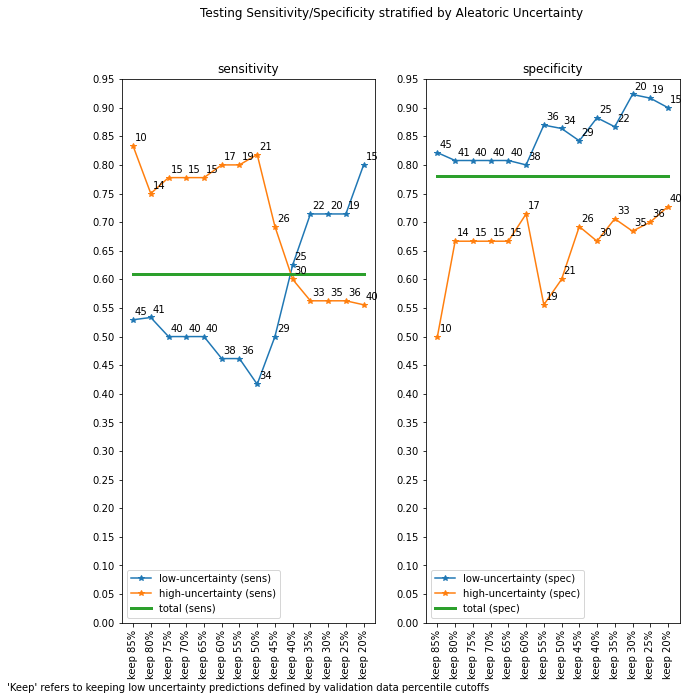

********************************************************************************
model 1


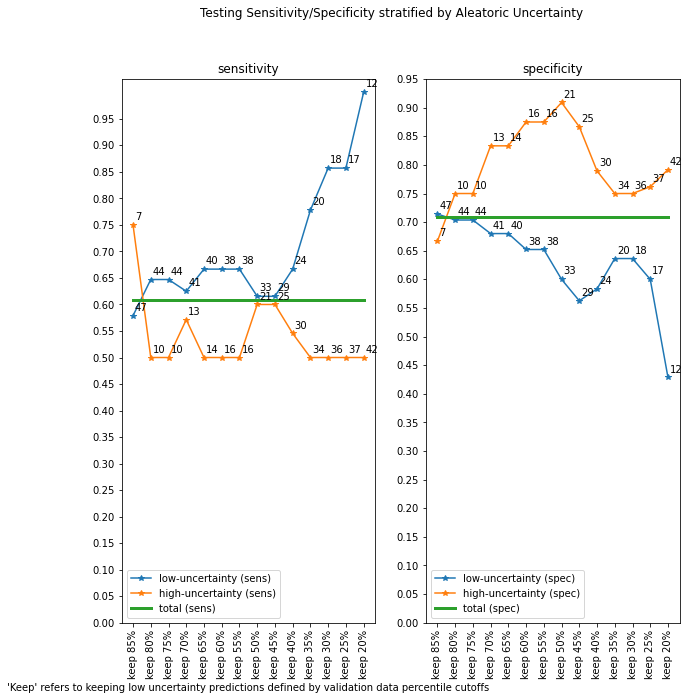

********************************************************************************
model 2


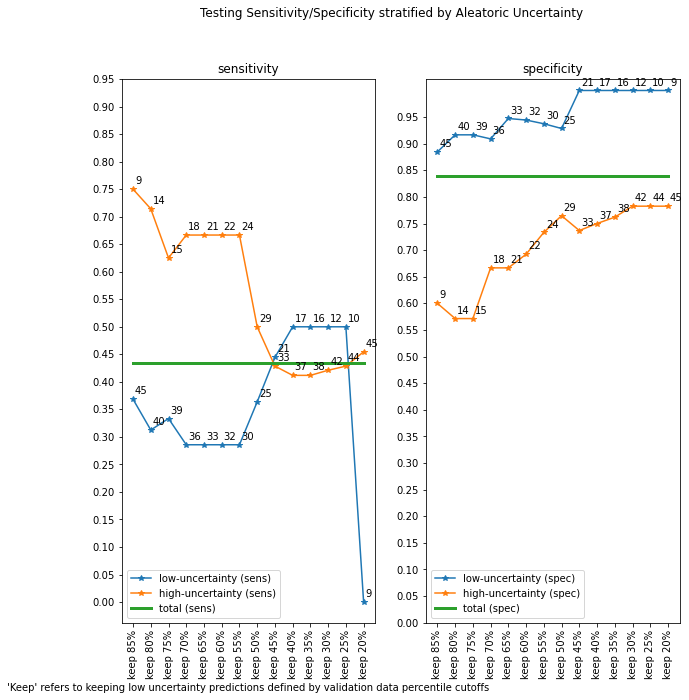

********************************************************************************
model 3


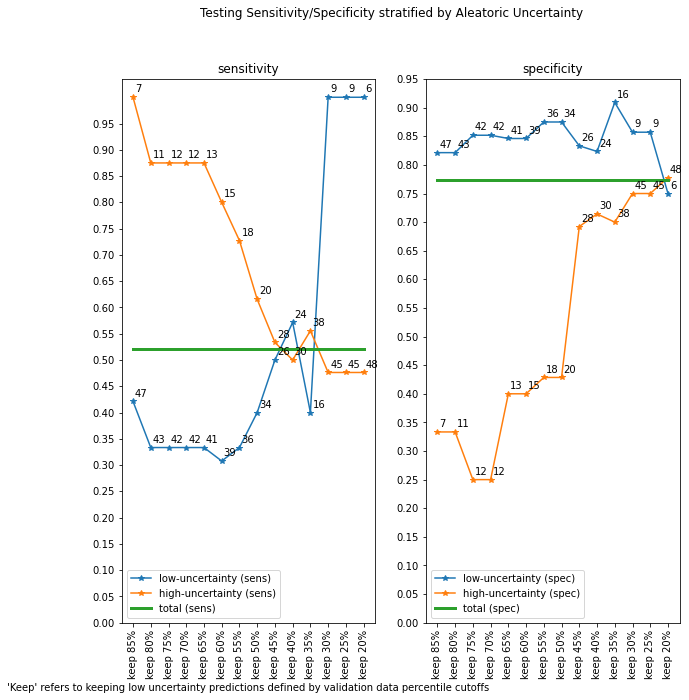

********************************************************************************
model 4


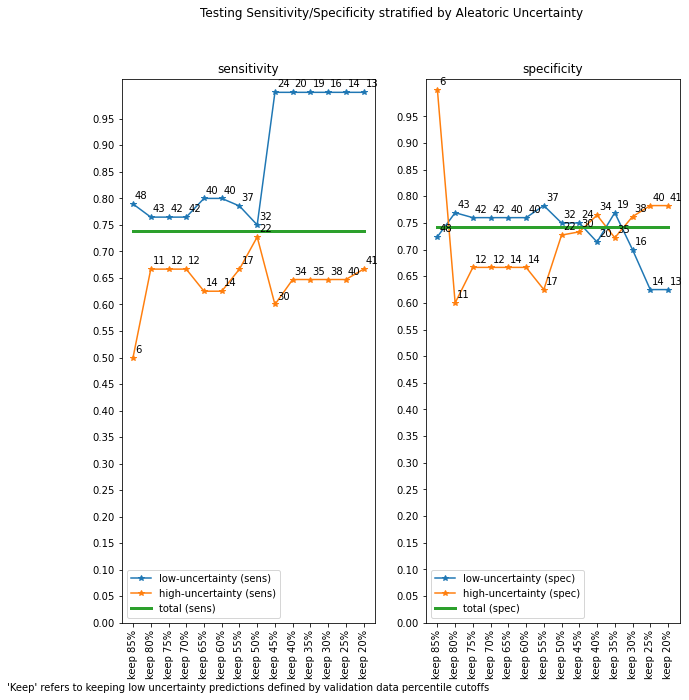

In [13]:
print('testing sens/spec')

dict_
for m in range(5):
    print('*'*80)
    print(f"model {m}")

    high_sens = [dict_['aleatoric'][f"model_{m}"][x]['h_sens'] for x in dict_['aleatoric'][f"model_{m}"] 
                        if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    high_uncertainty_num = [np.shape(dict_['aleatoric'][f"model_{m}"][x]['h_uncert_df'])[0] for x in dict_['aleatoric'][f"model_{m}"] 
                            if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    high_spec = [dict_['aleatoric'][f"model_{m}"][x]['h_spec'] for x in dict_['aleatoric'][f"model_{m}"] 
                        if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]


    low_sens = [dict_['aleatoric'][f"model_{m}"][x]['l_sens'] for x in dict_['aleatoric'][f"model_{m}"] 
                       if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    low_uncertainty_num = [np.shape(dict_['aleatoric'][f"model_{m}"][x]['l_uncert_df'])[0] for x in dict_['aleatoric'][f"model_{m}"] 
                           if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]

    low_spec = [dict_['aleatoric'][f"model_{m}"][x]['l_spec'] for x in dict_['aleatoric'][f"model_{m}"] 
                       if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]


    cutoff = [x.split('_')[-1] for x in dict_['aleatoric'][f"model_{m}"] 
              if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    
    cutoff = cutoff[::-1]
    high_sens = high_sens[::-1]
    high_uncertainty_num = high_uncertainty_num[::-1]
    high_spec = high_spec[::-1]
    
    low_sens = low_sens[::-1]
    low_uncertainty_num = low_uncertainty_num[::-1]
    low_spec = low_spec[::-1]


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

    ax1.plot([int(x) for x in cutoff], low_sens, '-*')
    
    for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
        ax1.annotate(str(txt), ([int(x) for x in cutoff][i], low_sens[i]), 
                     xycoords='data', textcoords='offset points', xytext=(2, 5))
    
    ax1.plot([int(x) for x in cutoff], high_sens, '*-')
    for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
        ax1.annotate(str(txt), ([int(x) for x in cutoff][i], high_sens[i]), 
                     xycoords='data', textcoords='offset points', xytext=(2, 5))
    
    
    ax1.plot([int(x) for x in cutoff], [dict_['aleatoric'][f"model_{m}"][x]['total_sens'] for x in dict_['aleatoric'][f"model_{m}"] 
              if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range], linewidth=3)
    
    ax1.legend(['low-uncertainty (sens)', 'high-uncertainty (sens)','total (sens)'], loc='lower left')
    ax1.invert_xaxis()
    ax1.set_xticks([int(x) for x in cutoff])
    ax1.set_xticklabels([f"keep {str(x)}%" for x in cutoff], rotation = 90)
    ax1.set_xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs")
    ax1.set_title('sensitivity')
    ax1.set_yticks(np.arange(0.0, 1, 0.05))
    
    # specificity
    
    ax2.plot([int(x) for x in cutoff], low_spec, '-*')
    
    for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
        ax2.annotate(str(txt), ([int(x) for x in cutoff][i], low_spec[i]), 
                     xycoords='data', textcoords='offset points', xytext=(2, 5))
    
    ax2.plot([int(x) for x in cutoff], high_spec, '*-')
    for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
        ax2.annotate(str(txt), ([int(x) for x in cutoff][i], high_spec[i]), 
                     xycoords='data', textcoords='offset points', xytext=(2, 5))
    
    ax2.plot([int(x) for x in cutoff], [dict_['aleatoric'][f"model_{m}"][x]['total_spec'] for x in dict_['aleatoric'][f"model_{m}"] 
              if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range], linewidth=3)
    
    ax2.legend(['low-uncertainty (spec)', 'high-uncertainty (spec)','total (spec)'], loc='lower left')
    ax2.set_yticks(np.arange(0.0, 1, 0.05))
    ax2.invert_xaxis()
    ax2.set_xticks([int(x) for x in cutoff])
    ax2.set_xticklabels([f"keep {str(x)}%" for x in cutoff], rotation = 90)

    ax2.set_title('specificity')

    fig.suptitle('Testing Sensitivity/Specificity stratified by Aleatoric Uncertainty')
    
    plt.show()

val total data


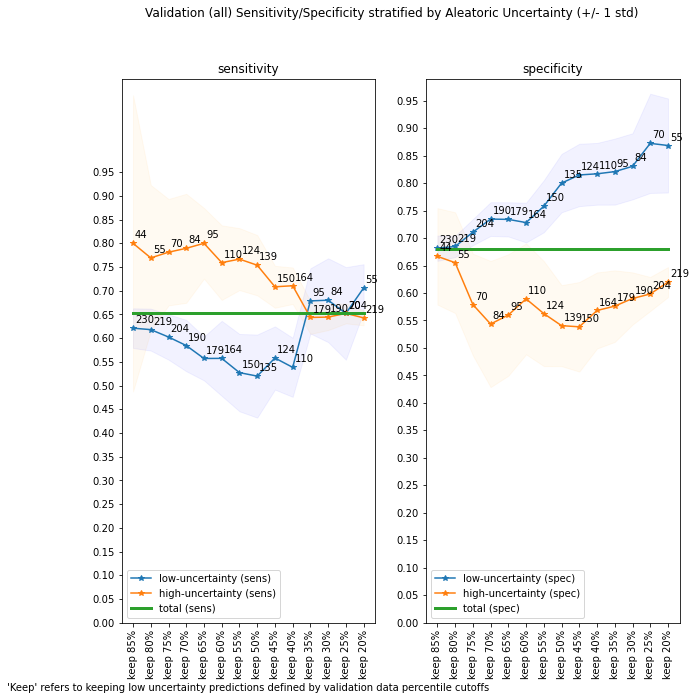

In [14]:
print('val total data')

std_num = 1
dict_val

total_eval_dict = {x: {} for x in cut_range}


for c in cut_range:
    high_uncertainty_df = None
    low_uncertainty_df = None
    
    low_sens_cut = []
    low_spec_cut = []
    
    high_sens_cut = []
    high_spec_cut = []
    
    for m in range(5):
        if m == 0:
            high_uncertainty_df = dict_val['aleatoric'][f"model_{m}"][f"c_{c}"]['h_uncert_df']
            low_uncertainty_df = dict_val['aleatoric'][f"model_{m}"][f"c_{c}"]['l_uncert_df']
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
            low_sens_cut.append(sensitivity)
            low_spec_cut.append(specificity)
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
            high_sens_cut.append(sensitivity)
            high_spec_cut.append(specificity)
            
        else:
            high_uncertainty_df = pd.concat([high_uncertainty_df, dict_val['aleatoric'][f"model_{m}"][f"c_{c}"]['h_uncert_df']])
            low_uncertainty_df = pd.concat([low_uncertainty_df, dict_val['aleatoric'][f"model_{m}"][f"c_{c}"]['l_uncert_df']])
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
            low_sens_cut.append(sensitivity)
            low_spec_cut.append(specificity)
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
            high_sens_cut.append(sensitivity)
            high_spec_cut.append(specificity)

        
    total_eval_dict[c]['total_df'] = pd.concat([high_uncertainty_df, low_uncertainty_df])   
    total_eval_dict[c]['high_uncertainty_df'] = high_uncertainty_df
    total_eval_dict[c]['high_uncertainty_num'] = np.shape(high_uncertainty_df)[0]

    total_eval_dict[c]['low_uncertainty_df'] = low_uncertainty_df
    total_eval_dict[c]['low_uncertainty_num'] = np.shape(low_uncertainty_df)[0]
    
    
    total_eval_dict[c]['fold_l_sens'] = low_sens_cut
    total_eval_dict[c]['fold_h_sens'] = high_sens_cut
    total_eval_dict[c]['fold_l_spec'] = low_spec_cut
    total_eval_dict[c]['fold_h_spec'] = high_spec_cut
    

    total_eval_dict[c]['l_sens_std'] = np.std(total_eval_dict[c]['fold_l_sens'])
    total_eval_dict[c]['h_sens_std'] = np.std(total_eval_dict[c]['fold_h_sens'])
    
    total_eval_dict[c]['l_spec_std'] = np.std(total_eval_dict[c]['fold_l_spec'])
    total_eval_dict[c]['h_spec_std'] = np.std(total_eval_dict[c]['fold_h_spec'])
    

    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true= total_eval_dict[c]['total_df']['true'], y_pred=total_eval_dict[c]['total_df']['pred_final'])
    total_eval_dict[c]['total_sens'] = sensitivity     
    total_eval_dict[c]['total_spec'] = specificity 

    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
    total_eval_dict[c]['h_sens'] = sensitivity
    total_eval_dict[c]['h_spec'] = specificity
    
    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
    total_eval_dict[c]['l_sens'] = sensitivity
    total_eval_dict[c]['l_spec'] = specificity
    
        
cutoff = cut_range
cutoff = cutoff[::-1]
low_uncertainty_num = [total_eval_dict[c]['low_uncertainty_num'] for c in cutoff]
high_uncertainty_num = [total_eval_dict[c]['high_uncertainty_num'] for c in cutoff]

 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

low_sens = [total_eval_dict[c]['l_sens'] for c in cutoff]
low_std_low = [total_eval_dict[c]['l_sens'] - std_num*total_eval_dict[c]['l_sens_std'] for c in cutoff]
low_std_high = [total_eval_dict[c]['l_sens'] + std_num*total_eval_dict[c]['l_sens_std'] for c in cutoff]

ax1.plot([int(x) for x in cutoff], low_sens, '-*')
ax1.fill_between([int(x) for x in cutoff], (low_std_low), (low_std_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    ax1.annotate(str(txt), ([int(x) for x in cutoff][i], low_sens[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))
    
high_sens = [total_eval_dict[c]['h_sens'] for c in cutoff]
high_std_low = [total_eval_dict[c]['h_sens'] - std_num*total_eval_dict[c]['h_sens_std'] for c in cutoff]
high_std_high = [total_eval_dict[c]['h_sens'] + std_num*total_eval_dict[c]['h_sens_std'] for c in cutoff]

ax1.plot([int(x) for x in cutoff], high_sens, '*-')
ax1.fill_between([int(x) for x in cutoff], (high_std_low), (high_std_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    ax1.annotate(str(txt), ([int(x) for x in cutoff][i], high_sens[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))


ax1.plot([int(x) for x in cutoff], [total_eval_dict[c]['total_sens'] for c in cutoff], linewidth=3)
ax1.legend(['low-uncertainty (sens)', 'high-uncertainty (sens)','total (sens)'], loc='lower left')
ax1.set_title('sensitivity')
ax1.invert_xaxis()
ax1.set_xticks([int(x) for x in cutoff])
ax1.set_xticklabels([f"keep {str(x)}%" for x in cutoff], rotation = 90)
ax1.set_xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs")
ax1.set_yticks(np.arange(0.0, 1, 0.05))

save_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_miccai\save_folder\sens_spec'
f_name = 'val_tta_sens.csv'
df = pd.DataFrame([[low_uncertainty_num, low_sens, [total_eval_dict[50]['total_sens'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'l_sens', 'total_sens'])
df.to_csv(os.path.join(save_dir, f_name))

f_name = 'val_tta_sens_wrong.csv'
df = pd.DataFrame([[high_uncertainty_num, high_sens, [total_eval_dict[50]['total_sens'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'h_sens', 'total_sens'])
df.to_csv(os.path.join(save_dir, f_name))

# specificity

low_spec = [total_eval_dict[c]['l_spec'] for c in cutoff]
low_std_low = [total_eval_dict[c]['l_spec'] - std_num*total_eval_dict[c]['l_spec_std'] for c in cutoff]
low_std_high = [total_eval_dict[c]['l_spec'] + std_num*total_eval_dict[c]['l_spec_std'] for c in cutoff]

ax2.plot([int(x) for x in cutoff], low_spec, '-*')
ax2.fill_between([int(x) for x in cutoff], (low_std_low), (low_std_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    ax2.annotate(str(txt), ([int(x) for x in cutoff][i], low_spec[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))
    
high_spec = [total_eval_dict[c]['h_spec'] for c in cutoff]
high_std_low = [total_eval_dict[c]['h_spec'] - std_num*total_eval_dict[c]['h_spec_std'] for c in cutoff]
high_std_high = [total_eval_dict[c]['h_spec'] + std_num*total_eval_dict[c]['h_spec_std'] for c in cutoff]

ax2.plot([int(x) for x in cutoff], high_spec, '*-')
ax2.fill_between([int(x) for x in cutoff], (high_std_low), (high_std_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    ax2.annotate(str(txt), ([int(x) for x in cutoff][i], high_spec[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))


ax2.plot([int(x) for x in cutoff], [total_eval_dict[c]['total_spec'] for c in cutoff], linewidth=3)
ax2.legend(['low-uncertainty (spec)', 'high-uncertainty (spec)','total (spec)'], loc='lower left')
ax2.set_yticks(np.arange(0.0, 1, 0.05))
ax2.invert_xaxis()
ax2.set_xticks([int(x) for x in cutoff])
ax2.set_xticklabels([f"keep {str(x)}%" for x in cutoff], rotation = 90)
ax2.set_title('specificity')
fig.suptitle(f"Validation (all) Sensitivity/Specificity stratified by Aleatoric Uncertainty (+/- {std_num} std)")

plt.show()

save_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_miccai\save_folder\sens_spec'
f_name = 'val_tta_spec.csv'
df = pd.DataFrame([[low_uncertainty_num, low_spec, [total_eval_dict[50]['total_spec'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'l_spec', 'total_spec'])
df.to_csv(os.path.join(save_dir, f_name))

f_name = 'val_tta_spec_wrong.csv'
df = pd.DataFrame([[high_uncertainty_num, high_spec, [total_eval_dict[50]['total_spec'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'h_spec', 'total_spec'])
df.to_csv(os.path.join(save_dir, f_name))

test total data


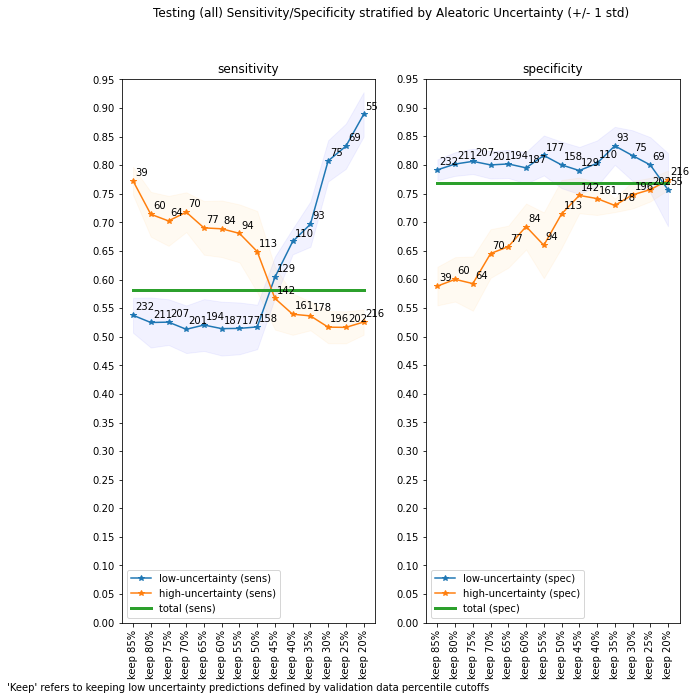

In [15]:
print('test total data')

std_num = 1

dict_

total_eval_dict = {x: {} for x in cut_range}


for c in cut_range:
    high_uncertainty_df = None
    low_uncertainty_df = None
    
    low_sens_cut = []
    low_spec_cut = []
    
    high_sens_cut = []
    high_spec_cut = []
    
    for m in range(5):
        if m == 0:
            high_uncertainty_df = dict_['aleatoric'][f"model_{m}"][f"c_{c}"]['h_uncert_df']
            low_uncertainty_df = dict_['aleatoric'][f"model_{m}"][f"c_{c}"]['l_uncert_df']
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
            low_sens_cut.append(sensitivity)
            low_spec_cut.append(specificity)
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
            high_sens_cut.append(sensitivity)
            high_spec_cut.append(specificity)
            
        else:
            high_uncertainty_df = pd.concat([high_uncertainty_df, dict_['aleatoric'][f"model_{m}"][f"c_{c}"]['h_uncert_df']])
            low_uncertainty_df = pd.concat([low_uncertainty_df, dict_['aleatoric'][f"model_{m}"][f"c_{c}"]['l_uncert_df']])
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
            low_sens_cut.append(sensitivity)
            low_spec_cut.append(specificity)
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
            high_sens_cut.append(sensitivity)
            high_spec_cut.append(specificity)

        
    total_eval_dict[c]['total_df'] = pd.concat([high_uncertainty_df, low_uncertainty_df])   
    total_eval_dict[c]['high_uncertainty_df'] = high_uncertainty_df
    total_eval_dict[c]['high_uncertainty_num'] = np.shape(high_uncertainty_df)[0]

    total_eval_dict[c]['low_uncertainty_df'] = low_uncertainty_df
    total_eval_dict[c]['low_uncertainty_num'] = np.shape(low_uncertainty_df)[0]
    
    
    total_eval_dict[c]['fold_l_sens'] = low_sens_cut
    total_eval_dict[c]['fold_h_sens'] = high_sens_cut
    total_eval_dict[c]['fold_l_spec'] = low_spec_cut
    total_eval_dict[c]['fold_h_spec'] = high_spec_cut
    

    total_eval_dict[c]['l_sens_std'] = np.std(total_eval_dict[c]['fold_l_sens'])
    total_eval_dict[c]['h_sens_std'] = np.std(total_eval_dict[c]['fold_h_sens'])
    
    total_eval_dict[c]['l_spec_std'] = np.std(total_eval_dict[c]['fold_l_spec'])
    total_eval_dict[c]['h_spec_std'] = np.std(total_eval_dict[c]['fold_h_spec'])
    

    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true= total_eval_dict[c]['total_df']['true'], y_pred=total_eval_dict[c]['total_df']['pred_final'])
    total_eval_dict[c]['total_sens'] = sensitivity     
    total_eval_dict[c]['total_spec'] = specificity 

    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
    total_eval_dict[c]['h_sens'] = sensitivity
    total_eval_dict[c]['h_spec'] = specificity
    
    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
    total_eval_dict[c]['l_sens'] = sensitivity
    total_eval_dict[c]['l_spec'] = specificity
    
        
cutoff = cut_range
cutoff = cutoff[::-1]
low_uncertainty_num = [total_eval_dict[c]['low_uncertainty_num'] for c in cutoff]
high_uncertainty_num = [total_eval_dict[c]['high_uncertainty_num'] for c in cutoff]

 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

low_sens = [total_eval_dict[c]['l_sens'] for c in cutoff]
low_std_low = [total_eval_dict[c]['l_sens'] - std_num*total_eval_dict[c]['l_sens_std'] for c in cutoff]
low_std_high = [total_eval_dict[c]['l_sens'] + std_num*total_eval_dict[c]['l_sens_std'] for c in cutoff]

ax1.plot([int(x) for x in cutoff], low_sens, '-*')
ax1.fill_between([int(x) for x in cutoff], (low_std_low), (low_std_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    ax1.annotate(str(txt), ([int(x) for x in cutoff][i], low_sens[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))
    
high_sens = [total_eval_dict[c]['h_sens'] for c in cutoff]
high_std_low = [total_eval_dict[c]['h_sens'] - std_num*total_eval_dict[c]['h_sens_std'] for c in cutoff]
high_std_high = [total_eval_dict[c]['h_sens'] + std_num*total_eval_dict[c]['h_sens_std'] for c in cutoff]

ax1.plot([int(x) for x in cutoff], high_sens, '*-')
ax1.fill_between([int(x) for x in cutoff], (high_std_low), (high_std_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    ax1.annotate(str(txt), ([int(x) for x in cutoff][i], high_sens[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))


ax1.plot([int(x) for x in cutoff], [total_eval_dict[c]['total_sens'] for c in cutoff], linewidth=3)
ax1.legend(['low-uncertainty (sens)', 'high-uncertainty (sens)','total (sens)'], loc='lower left')
ax1.set_title('sensitivity')
ax1.invert_xaxis()
ax1.set_xticks([int(x) for x in cutoff])
ax1.set_xticklabels([f"keep {str(x)}%" for x in cutoff], rotation = 90)
ax1.set_xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs")
ax1.set_yticks(np.arange(0.0, 1, 0.05))

save_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_miccai\save_folder\sens_spec'
f_name = 'test_tta_sens.csv'
df = pd.DataFrame([[low_uncertainty_num, low_sens, [total_eval_dict[50]['total_sens'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'l_sens', 'total_sens'])
df.to_csv(os.path.join(save_dir, f_name))

f_name = 'test_tta_sens_wrong.csv'
df = pd.DataFrame([[high_uncertainty_num, high_sens, [total_eval_dict[50]['total_sens'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'h_sens', 'total_sens'])
df.to_csv(os.path.join(save_dir, f_name))

# specificity

low_spec = [total_eval_dict[c]['l_spec'] for c in cutoff]
low_std_low = [total_eval_dict[c]['l_spec'] - std_num*total_eval_dict[c]['l_spec_std'] for c in cutoff]
low_std_high = [total_eval_dict[c]['l_spec'] + std_num*total_eval_dict[c]['l_spec_std'] for c in cutoff]

ax2.plot([int(x) for x in cutoff], low_spec, '-*')
ax2.fill_between([int(x) for x in cutoff], (low_std_low), (low_std_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    ax2.annotate(str(txt), ([int(x) for x in cutoff][i], low_spec[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))
    
high_spec = [total_eval_dict[c]['h_spec'] for c in cutoff]
high_std_low = [total_eval_dict[c]['h_spec'] - std_num*total_eval_dict[c]['h_spec_std'] for c in cutoff]
high_std_high = [total_eval_dict[c]['h_spec'] + std_num*total_eval_dict[c]['h_spec_std'] for c in cutoff]

ax2.plot([int(x) for x in cutoff], high_spec, '*-')
ax2.fill_between([int(x) for x in cutoff], (high_std_low), (high_std_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    ax2.annotate(str(txt), ([int(x) for x in cutoff][i], high_spec[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))


ax2.plot([int(x) for x in cutoff], [total_eval_dict[c]['total_spec'] for c in cutoff], linewidth=3)
ax2.legend(['low-uncertainty (spec)', 'high-uncertainty (spec)','total (spec)'], loc='lower left')
ax2.set_yticks(np.arange(0.0, 1, 0.05))
ax2.invert_xaxis()
ax2.set_xticks([int(x) for x in cutoff])
ax2.set_xticklabels([f"keep {str(x)}%" for x in cutoff], rotation = 90)
ax2.set_title('specificity')
fig.suptitle(f"Testing (all) Sensitivity/Specificity stratified by Aleatoric Uncertainty (+/- {std_num} std)")

plt.show()

save_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_miccai\save_folder\sens_spec'
f_name = 'test_tta_spec.csv'
df = pd.DataFrame([[low_uncertainty_num, low_spec, [total_eval_dict[50]['total_spec'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'l_spec', 'total_spec'])
df.to_csv(os.path.join(save_dir, f_name))

f_name = 'test_tta_spec_wrong.csv'
df = pd.DataFrame([[high_uncertainty_num, high_spec, [total_eval_dict[50]['total_spec'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'h_spec', 'total_spec'])
df.to_csv(os.path.join(save_dir, f_name))